In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 11 13:40:03 2016

@author: vlchaplin@gmail.com
"""

#import h5py
#import sys
import numpy as np
#from scipy import io
#from scipy.signal import hilbert as hilbert
from math import *;
#
#import re
#import glob
#import os
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib.gridspec as gridspec
#from matplotlib.backends.backend_pdf import PdfPages

from scipy.interpolate import interp1d

import pandas


plt_attr={}
plt_attr["single"]=dict(color=(0,0,1), marker="o")
plt_attr["multi_1"]=dict(color=(0.9,0.1,0), marker="^")
plt_attr["multi_2"]=dict(color=(0.5,0.5,0), marker="s" )

plt_label={}
plt_label["single"]=dict(label="single")
plt_label["multi_1"]=dict(label="4mm" )
plt_label["multi_2"]=dict(label="8mm" )
def grnumaxis(nslc):
    sqr=np.sqrt(nslc)
    if np.abs(np.mod( sqr, 1.0))<1e-16:
        #is perfect square
        nnc=int(sqr)
    else:
        nnc=floor(sqr)+1
    
    nnr = ceil(nslc/nnc)

    return (nnr,nnc)
def grax_ij(slidx, nnr,nnc):
    j_ax = np.mod(slidx,nnc)
    i_ax = floor(slidx/nnc)
    return (i_ax,j_ax)


#%%

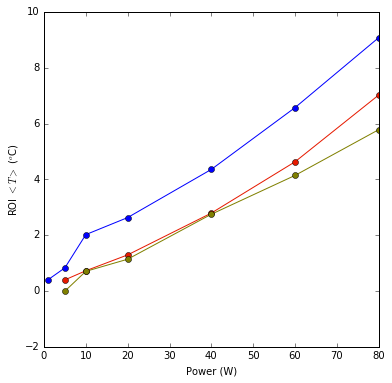

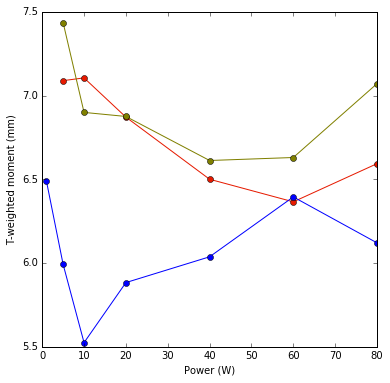

In [4]:
mrisets = [ 
    dict(use=1, path='/Users/Vandiver/Data/Verasonics/sonalleve_20160709/',
            pars='HifuScanParameters.csv', temp='scans_batch_DT_unwr_20160709.csv'),
    dict(use=1, path='/Users/Vandiver/Data/sonalleve/HifuCav20160810/',
            pars='HifuScanParams.csv', temp='scans_batch_DT_unwr_20160810.csv')]
            
tempfile='/Users/Vandiver/Data/Verasonics/cav_scans_batch_DT_unwr2.csv'

merged_frames=[]
for mi in range(len(mrisets)):
    
    if not mrisets[mi]['use']:
        continue
    
    parsfile=mrisets[mi]['path']+mrisets[mi]['pars']
    scanHifuParams = pandas.read_csv(parsfile)
            
    #tempfile=mrisets[mi]['path']+mrisets[mi]['temp']
    scanAnalysisDT = pandas.read_csv(tempfile)
    
    
    merged = scanAnalysisDT.merge(scanHifuParams)
    merged_frames.append(merged)
    
merged = pandas.concat(merged_frames)
#%%

grouped = merged.query("material=='phantom'").groupby(['tag','material'])
#computed = grouped['finalT'].agg([np.min, np.max])

fig=plt.figure(figsize=(6,6))

for gidx,rowids in grouped:
    
    case=gidx[0]
    g=grouped.get_group(gidx).groupby('power')
    
    powers = list(g.groups.keys())  
    
    avgTr = g['finalT'].agg([np.min, np.max, np.mean])
    #numr = g['n5'].agg([np.min, np.max])
    #n10r = g['n10'].agg([np.min, np.max])
    #n15r = g['n15'].agg([np.min, np.max])

    plt.plot(avgTr.index, avgTr['mean'], 'o-',**plt_attr[case])
    plt.xlabel('Power (W)')
    plt.ylabel('ROI $<T>$ ($^o$C)')
    
fig=plt.figure(figsize=(6,6))

for gidx,rowids in grouped:
    
    case=gidx[0]
    g=grouped.get_group(gidx).groupby('power')
    
    TwSize=g['momR'].agg([np.mean])

    plt.plot(TwSize.index, TwSize['mean'], 'o-',**plt_attr[case])
    plt.xlabel('Power (W)')
    plt.ylabel('T-weighted moment (mm)')
    
#%%
    
#Tvalues = np.array(list( map ( lambda crv: max(map(float,crv[1:-1].split())), subset.maxT)  ))
        
def vectorstr2arr(panda_vec_string,dtype=np.float):
    return np.array(list(map(float,panda_vec_string[1:-1].split())), dtype=dtype)
    

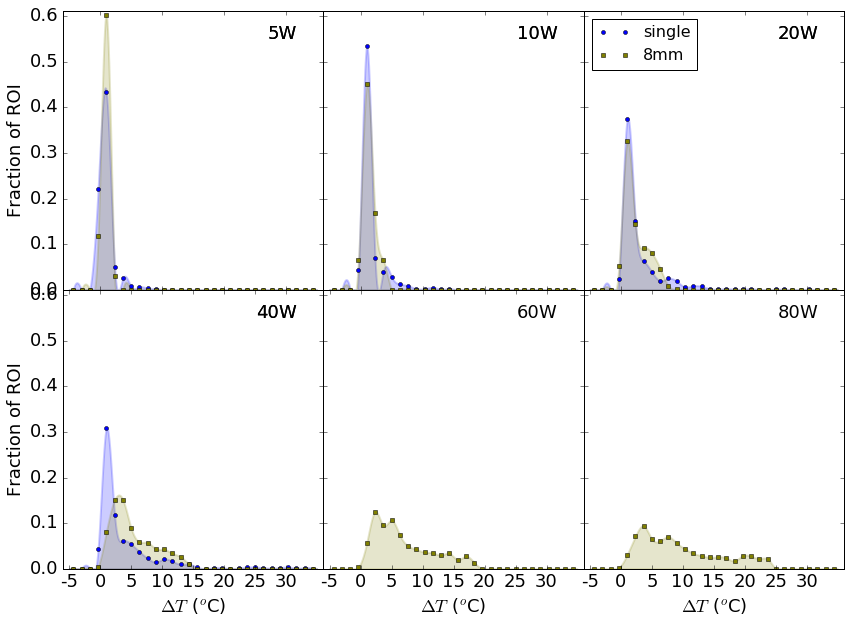

In [95]:
powers=[5,10,20,40,60,80]
powAxLookup={'val':powers,'axi':list(range(len(powers)))}
powAxLookup = pandas.DataFrame(powAxLookup,index=powAxLookup['val'])

(nnr,nnc) = grnumaxis(len(powers))
gsPows=gridspec.GridSpec( nnr, nnc, wspace=0.00,hspace=0.00)

cases=["single","multi_1", "multi_2"]


#fig=plt.figure(figsize=(9,6))
fig2=plt.figure(figsize=(14,10))

ax2s=[]
for pi in range(len(powers)):
    (ii,jj) = grax_ij(pi,nnr,nnc)
    ax2s.append( fig2.add_subplot(gsPows[ii, jj])  )



#dataset=merged.query("material=='phantom'").query("tag=='single'")

#cases=['single']

hmax=0

for ci in range(0,len(cases)):
    
    case=cases[ci]

    dataset=merged.query("material=='pork'").query("tag=='%s'"%(case)).sort_values(by='power')

    if dataset.size==0:
        continue
    #row=dataset.iloc[0]
    
    pgrouped=dataset.groupby('power')
    powlist=sorted( pgrouped.groups.keys() )
    
    #powlist=powers
    
    numTrialsPerPower=pgrouped.size()
    #concat the groups if more than trial exists
    tempvecsVsPower=[]
    for pi in powlist:
        #subframe= pgrouped.get_group(pi).maxTdata
        try:
            subframe= pgrouped.get_group(pi).maxTdata
        except KeyError:
            continue
        temperatures = vectorstr2arr( subframe.iloc[0] )
        
        for gi in range(1,numTrialsPerPower[pi]):
            temperatures = np.concatenate( [temperatures, vectorstr2arr( subframe.iloc[gi] )] )
        
        tempvecsVsPower.append(temperatures)

    for pwi in range(len(powlist)):
        p=powlist[pwi]
        try:
            pax=powAxLookup.loc[p].axi
        except KeyError:
            continue
        #pax=powAxLookup.loc[p].axi
        
        (hy,hx) = np.histogram(tempvecsVsPower[pwi],bins=30,range=[-5,35],normed=True)        
        
        hxc = (hx[0:-1] + hx[1:] )/2
        hinterp = interp1d( hxc, hy, kind='cubic', fill_value=0,bounds_error=False)
        
        xip = np.arange(hx[0], hx[-1], .1)
        kwarg=dict(linewidth=2.0)
        
        (xx,yy) = (xip, hinterp(xip))
        yy[yy<0]=0
        
        if np.max(hy)>hmax:
            hmax=np.max(hy)
        
        ii,jj = grax_ij(pwi,nnr,nnc)
        
        
        ax2s[pax].fill_between(xx,yy,alpha=0.2, color=plt_attr[case]['color'], step=None,**kwarg) 
        ax2s[pax].plot(hxc,hy,'.', label=plt_label[case]['label'], markersize=4, **plt_attr[case])
        ax2s[pax].tick_params(labelsize=18)
        ax2s[pax].set_xlabel('$\Delta T$ ($^o$C)',fontsize=18)
        ax2s[pax].set_ylabel('Fraction of ROI',fontsize=18)
        ax2s[pax].text(0.9,0.9,'%dW'%p, transform=ax2s[pax].transAxes, horizontalalignment='right', fontsize=18,color='k')
        
        if jj != 0:
            #ax2s[pax].axes.yaxis.set_ticks([])
            ax2s[pax].axes.yaxis.set_ticklabels([])
            ax2s[pax].set_ylabel('')
        if ii==0:
            ax2s[pax].axes.xaxis.set_ticklabels([])
            ax2s[pax].set_xlabel('')
        if ii==1:
            xlocls=np.arange(-5,30.1,5)
            ax2s[pax].set_xticklabels(list(map( lambda x: "%d"%x,xlocls) ) )
            ax2s[pax].set_xticks(xlocls)
            #ax2s[pax].set_xticklabels(np.arange(0,30.1,5) )
            
        
for ax in ax2s:
    ax.set_ylim([0, hmax+0.01])
    ax.set_xlim([-6,36])
    #ax.set_yscale('log')
    
ax2s[2].legend(loc=2,fontsize=16)

In [97]:
fig2.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/Pork_TempHistogram.png")
plt.close(fig2)

In [35]:
ax.set_x

,axi,val
5,0,5
10,1,10
20,2,20
40,3,40
60,4,60
80,5,80
